In [6]:
import torch
import torch.nn as nn

class WordEmbeddingModule(nn.Module):

    def __init__(self, vocab_size, embedding_size, word_embedding_model=None):
        super(WordEmbeddingModule, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_size = embedding_size

        if word_embedding_model:
            weights = torch.tensor(word_embedding_model.wv.syn0)
            weights = torch.cat((torch.zeros(1,self.embedding_size), weights), dim=0)
            self.embedding_layer = nn.Embedding(self.vocab_size + 1, self.embedding_size, padding_idx=0).from_pretrained(weights, freeze=True)
        else:
            self.embedding_layer = nn.Embedding(self.vocab_size + 1, self.embedding_size, padding_idx=0)

    def forward(self, sentences):
        ## sentences: bs * M/L

        sentences = self.embedding_layer(sentences)
        ## bs * M/L * d

        return sentences


class CNN(nn.Module):

    def __init__(self, embedding_size, convolutional_filters, context_len):
        super(CNN, self).__init__()

        self.embedding_size = embedding_size
        self.convolutional_filters = convolutional_filters
        self.context_len = context_len

        self.conv = nn.Conv1d(self.embedding_size, self.convolutional_filters, self.context_len, padding=1)

    def forward(self, sentence):
        ## question: bs * M * d
        ## answer: bs * L * d

        sentence = sentence.transpose(1, 2)
        ## bs * d * M/L

        sentence = self.conv(sentence)
        ## bs * c * M/L

        return sentence


class biLSTM(nn.Module):

    def __init__(self, max_len, embedding_size, hidden_dim, device):
        super(biLSTM, self).__init__()

        hidden_dim = int(hidden_dim/2)
        self.device = device
        self.max_len = max_len
        self.hidden_dim = hidden_dim
        self.embedding_size = embedding_size

        self.lstm = nn.LSTM(embedding_size, hidden_dim, bidirectional=True)

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.zeros(2, self.max_len, self.hidden_dim),
                torch.zeros(2, self.max_len, self.hidden_dim))

    def forward(self, x):
        out, self.hidden = self.lstm(x, self.hidden)
        ## bs*M*c
        out = out.transpose(1,2)
        ## bs*c*M
        return out


class AttentivePoolingNetwork(nn.Module):

    def __init__(self, vocab_size, embedding_size , word_embedding_model=None, type_of_nn='CNN', convolutional_filters=400, context_len=3):
        super(AttentivePoolingNetwork, self).__init__()

        self.convolutional_filters = convolutional_filters
        self.context_len = context_len
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size

        self.embedding_layer = WordEmbeddingModule(vocab_size, embedding_size, word_embedding_model)

        ## CNN or biLSTM
        if type_of_nn == 'CNN':
            self.cnn_bilstm = CNN(self.embedding_size, self.convolutional_filters, self.context_len)
        elif type_of_nn == 'biLSTM':
            raise ValueError('Not implemented yet')
            #self.question_cnn_bilstm = biLSTM(self.M, self.embedding_size, self.convolutional_filters, self.device)
            #self.answer_cnn_bilstm = biLSTM(self.L, self.embedding_size, self.convolutional_filters, self.device)
        else:
            raise ValueError('Mode must be CNN or biLSTM')

        #self.U = torch.nn.Parameter(torch.Tensor(self.convolutional_filters, self.convolutional_filters))
        #torch.nn.init.normal_(self.U, mean=0, std=0.1)
        self.U = nn.Linear(self.convolutional_filters, self.convolutional_filters, bias=False)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, question, answer):
        ## question: bs * M
        ## answer: bs * L

        question = self.embedding_layer(question)
        ## bs * M * d
        answer = self.embedding_layer(answer)
        ## bs * M * d

        Q = self.cnn_bilstm(question)
        ## bs * c * M
        A = self.cnn_bilstm(answer)
        ## bs * c * L

        G = torch.tanh(self.U(Q.transpose(1,2)).matmul(A))
        ## bs * M * L

        roQ = torch.max(G, dim=2)[0]
        ## bs * M
        roA = torch.max(G, dim=1)[0]
        ## bs * L

        roQ = self.softmax(roQ)
        ## bs * M
        roA = self.softmax(roA)
        ## bs * L

        rQ = Q.matmul(roQ.unsqueeze(2)).squeeze()
        ## bs * c
        rA = A.matmul(roA.unsqueeze(2)).squeeze()
        ## bs * c

        return torch.nn.functional.cosine_similarity(rQ, rA, dim=1, eps=1e-08)
        ## bs


class ClassicQANetwork(nn.Module):
    def __init__(self, vocab_size, embedding_size, word_embedding_model=None, convolutional_filters=400, context_len=3):
        super(ClassicQANetwork, self).__init__()

        self.convolutional_filters = convolutional_filters
        self.context_len = context_len
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size

        self.embedding_layer = WordEmbeddingModule(vocab_size, embedding_size, word_embedding_model)

        self.cnn = CNN(self.embedding_size, self.convolutional_filters, self.context_len)


    def forward(self, question, answer):
        ## question: bs * M
        ## answer: bs * L

        question = self.embedding_layer(question)
        ## bs * M * d
        answer = self.embedding_layer(answer)
        ## bs * M * d

        Q = self.cnn(question)
        ## bs * c * M
        A = self.cnn(answer)
        ## bs * c * L

        rQ = torch.max(Q, dim=2)[0]
        ## bs * c
        rA = torch.max(A, dim=2)[0]
        ## bs * c

        rQ = torch.tanh(rQ)
        ## bs * c
        rA = torch.tanh(rA)
        ## bs * c

        return torch.nn.functional.cosine_similarity(rQ, rA, dim=1, eps=1e-08)
        ## bs

In [7]:
net = AttentivePoolingNetwork(1000, 30, None)

In [8]:
[x.size() for x in net.parameters()]

[torch.Size([1001, 30]),
 torch.Size([400, 30, 3]),
 torch.Size([400]),
 torch.Size([400, 400])]

In [9]:
import torch
from torch import nn
from torchviz import make_dot, make_dot_from_trace

In [10]:
x = torch.randint(0,1000,(4,10))

In [11]:
x

tensor([[846, 744, 117, 555, 596, 414, 347, 444, 238, 139],
        [ 43, 890, 859, 151, 662, 990, 438, 232, 434, 585],
        [314, 483,  27, 793,  47,  92, 962, 622, 259, 893],
        [833, 562, 551,  64, 344, 363, 656, 713, 915, 220]])

In [12]:
x.size()

torch.Size([4, 10])

In [13]:
out = net(x,x)

In [14]:
out

tensor([1.0000, 0.9991, 0.9999, 1.0000], grad_fn=<DivBackward0>)

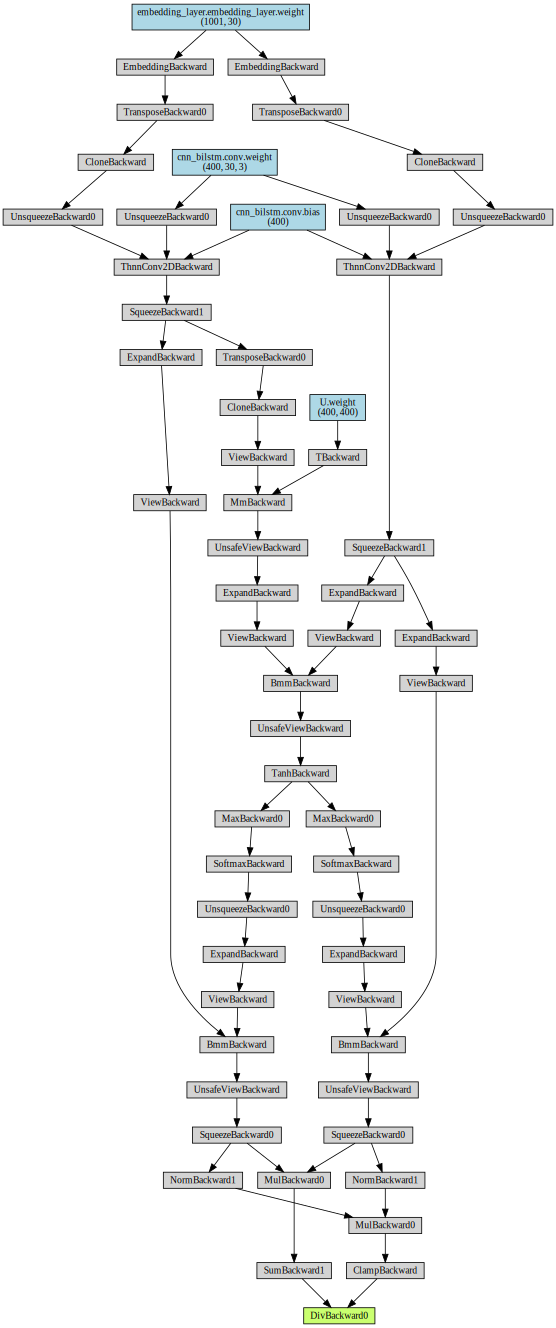

In [15]:
make_dot(out, params=dict(net.named_parameters()))